<a href="https://colab.research.google.com/github/Sofismarilla/PatientVisitsForecasting/blob/main/EDA_Patient_Visits_Forecasting_for_Allocation_Decision_of_Healthcare_%5BGroupTestA%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploratory Data Analysis Medical Laboratory's Dataset [GroupTestA]**

## **Step#0 Fire System**

In [2]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn
!pip install statsmodels
!pip install --user scipy==1.2.0
!pip install -U statsmodels

     |████████████████████████████████| 1.5MB 12.1MB/s 
     |████████████████████████████████| 9.5MB 54.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 358kB 14.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=d6313b0fcc69e89ceb3800b6609ceb7c048061687c46835e8c859d19a2334803
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 46.9MB 65kB/s 
     |████████████████████████████████| 901kB 61.3MB/s 
     |████████████████████████████████| 10.1MB 44.1MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 7.1MB 10.2MB/s 
ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1

In [3]:
import warnings
import numpy as np
import pandas as pd

# Data visualization
import time
import folium
import datetime
%matplotlib inline
import seaborn as sns 
import matplotlib as mpl
import plotly.express as px
from datetime import datetime
import plotly.graph_objs as go
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython.display import display, HTML, display_html

# Method Requirement
import glob
import keras
import sklearn
import tensorflow as tf
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model, save_model
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Statistics 
import scipy
from math import sqrt
from time import time
from scipy import stats
import statsmodels as sms
from timeit import default_timer as timer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('white')
warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = False
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## **Step#1 Read Data**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/THESIS/Dataset/dateset_patient.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1348 non-null   object
 1   hm        1348 non-null   int64 
 2   hm_aw     1348 non-null   int64 
 3   hm_am     1348 non-null   int64 
 4   cc        1348 non-null   int64 
 5   cc_aw     1348 non-null   int64 
 6   cc_am     1348 non-null   int64 
 7   day_week  1348 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 84.4+ KB


In [7]:
df.head(5)

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week
0,7/1/2017,66,48,63,44,37,45,6
1,7/2/2017,53,53,62,72,37,43,7
2,7/3/2017,74,54,59,87,42,44,1
3,7/4/2017,87,56,57,58,49,44,2
4,7/5/2017,95,62,58,72,53,44,3


## **Step #2. Data Preprocessing**

### **Decompose Datetime**

In [30]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['weekday']= df.apply(lambda row: row['date'].weekday(),axis=1)
df['weekday'] = (df["weekday"] < 5).astype(int)

df = df.loc[:,['date', 'year', 'month', 'day', 'day_week', 'weekday', 'hm', 'hm_aw', 'hm_am']]

### **Picking Features**

In [31]:
df.head(10)

,date,year,month,day,day_week,weekday,hm,hm_aw,hm_am
0,2017-07-01,2017,7,1,6,0,66,48,63
1,2017-07-02,2017,7,2,7,0,53,53,62
2,2017-07-03,2017,7,3,1,1,74,54,59
3,2017-07-04,2017,7,4,2,1,87,56,57
4,2017-07-05,2017,7,5,3,1,95,62,58
5,2017-07-06,2017,7,6,4,1,94,68,58
6,2017-07-07,2017,7,7,5,1,85,73,59
7,2017-07-08,2017,7,8,6,0,81,79,59
8,2017-07-09,2017,7,9,7,0,57,81,60
9,2017-07-10,2017,7,10,1,1,77,82,60


In [32]:
print('The time series starts from: ', df.date.min())
print('The time series ends on: ', df.date.max())
print('The Total data:', len(df))

The time series starts from:  2017-07-01 00:00:00
The time series ends on:  2021-03-09 00:00:00
The Total data: 1348


## **Step#3 Plotting data**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5cb70abe10>,
      dtype=object)

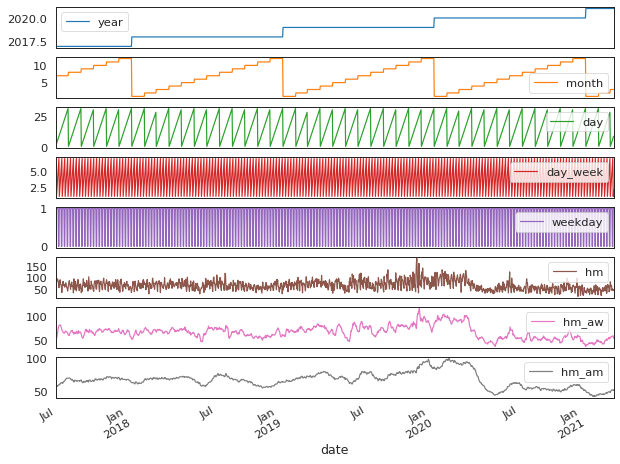

In [13]:
df.set_index('date')[['year', 'month', 'day', 'day_week', 'weekday', 'hm', 'hm_aw', 'hm_am']].plot(subplots=True)

In [33]:
df.set_index('date',inplace=True)

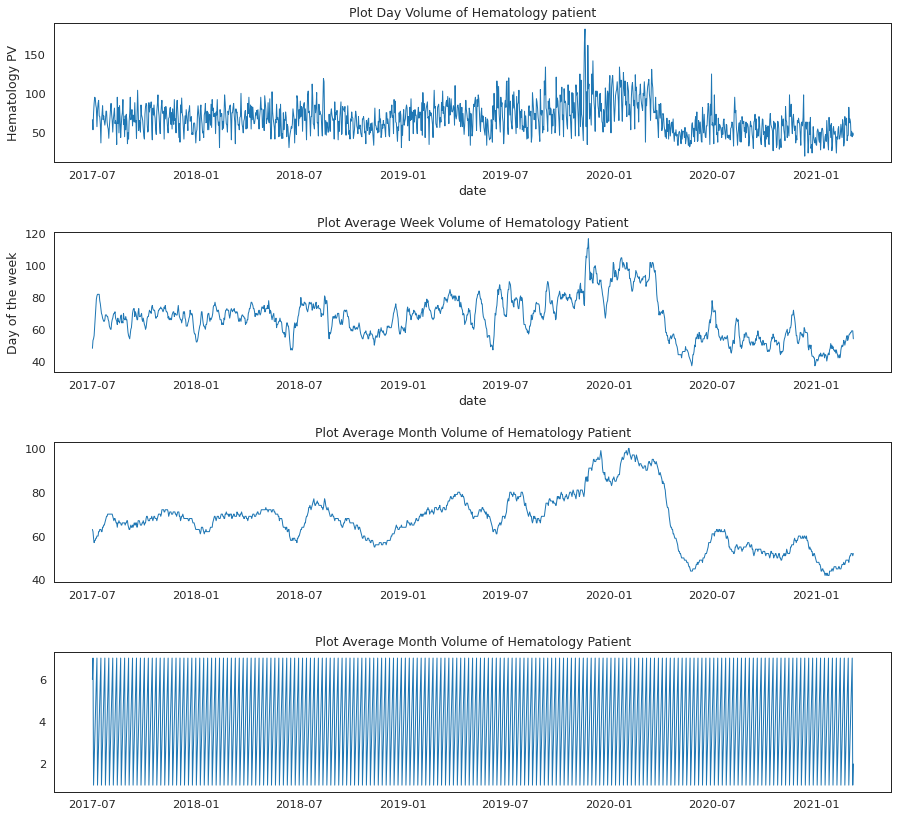

In [34]:
fig = plt.figure(figsize=(15,18))
fig.subplots_adjust(hspace=.5)
plt.tight_layout()

p1 = fig.add_subplot(5,1,1)
p1.plot(df['hm'],linewidth=1)
p1.set_title('Plot Day Volume of Hematology patient')
p1.set_ylabel('Hematology PV')
p1.set_xlabel('date')
p1.tick_params(axis='both', which='major')

p2 = fig.add_subplot(5,1,2, sharex=p1)
p2.plot(df['hm_aw'],linewidth=1)
p2.set_title('Plot Average Week Volume of Hematology Patient')
p2.set_ylabel('Hematology PV')
p2.set_xlabel('date')
p2.tick_params(axis='both', which='major')

p3 = fig.add_subplot(5,1,3, sharex=p2)
p3.plot(df['hm_am'],linewidth=1)
p3.set_title('Plot Average Month Volume of Hematology Patient')
p2.set_ylabel('Hematology PV')
p2.set_xlabel('date')
p3.tick_params(axis='both', which='major')

p4 = fig.add_subplot(5,1,4, sharex=p3)
p4.plot(df['day_week'],linewidth=1)
p4.set_title('Plot Average Month Volume of Hematology Patient')
p2.set_ylabel('Day of the week')
p2.set_xlabel('date')
p4.tick_params(axis='both', which='major')

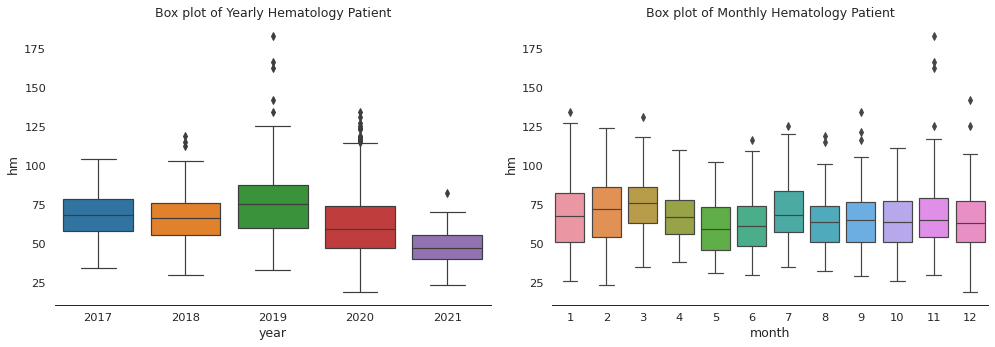

In [35]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="hm", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Hematology Patient')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x="month", y="hm", data=df)
plt.xlabel('month')
plt.title('Box plot of Monthly Hematology Patient')
sns.despine(left=True)
plt.tight_layout();

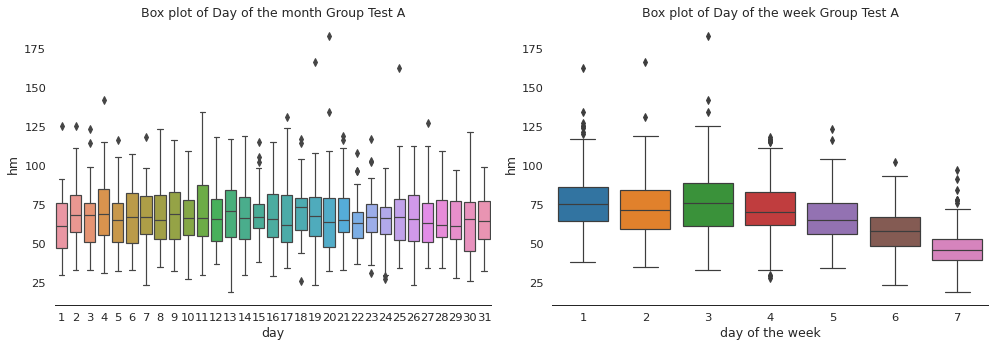

In [36]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="day", y="hm", data=df)
plt.xlabel('day')
plt.title('Box plot of Day of the month Group Test A')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x="day_week", y="hm", data=df)
plt.xlabel('day of the week')
plt.title('Box plot of Day of the week Group Test A')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
year,1348.0000,2018.8286,1.1232,2017.0000,2018.0000,2019.0000,2020.0000,2021.0000
month,1348.0000,6.6832,3.5314,1.0000,3.0000,7.0000,10.0000,12.0000
day,1348.0000,15.6558,8.8192,1.0000,8.0000,16.0000,23.0000,31.0000
day_week,1348.0000,4.0000,2.0026,1.0000,2.0000,4.0000,6.0000,7.0000
weekday,1348.0000,0.7136,0.4522,0.0000,0.0000,1.0000,1.0000,1.0000
hm,1348.0000,67.2315,20.3556,19.0000,53.0000,66.0000,79.0000,183.0000
hm_aw,1348.0000,67.2352,13.4192,37.0000,57.0000,67.5000,74.0000,117.0000
hm_am,1348.0000,67.2604,12.0619,42.0000,59.0000,68.0000,73.0000,100.0000


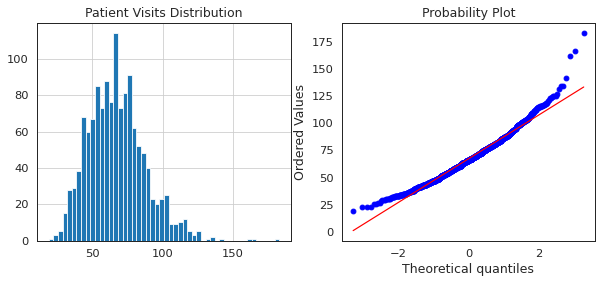

In [37]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
df['hm'].hist(bins=50)
plt.title('Patient Visits Distribution')
plt.subplot(1,2,2)
stats.probplot(df['hm'], plot=plt);
df.describe().T

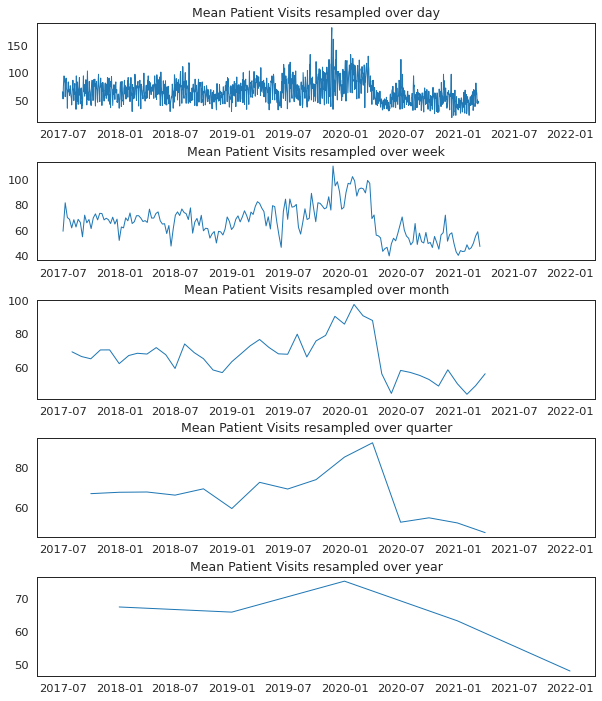

In [38]:
fig = plt.figure(figsize=(10,12))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df['hm'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Patient Visits resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df['hm'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Patient Visits resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df['hm'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Patient Visits resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df['hm'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Patient Visits resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df['hm'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Patient Visits resampled over year')
ax5.tick_params(axis='both', which='major');

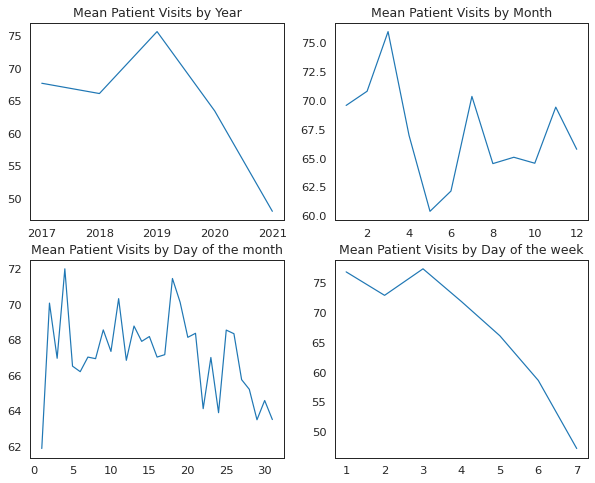

In [39]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
df.groupby('year').hm.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Patient Visits by Year')

plt.subplot(2,2,2)
df.groupby('month').hm.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Patient Visits by Month')

plt.subplot(2,2,3)
df.groupby('day').hm.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Patient Visits by Day of the month')

plt.subplot(2,2,4)
df.groupby('day_week').hm.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Patient Visits by Day of the week');

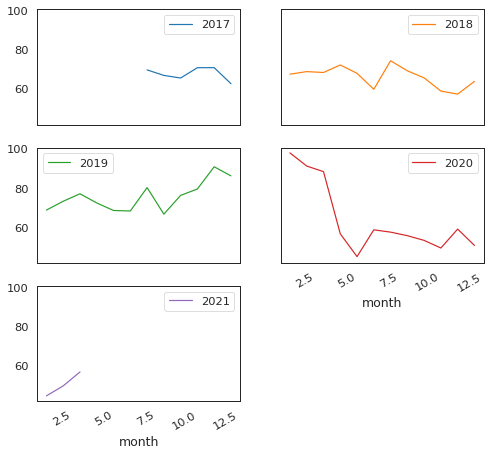

In [20]:
pd.pivot_table(df.loc[df['year'] != 2016], values = "hm", 
               columns = "year", index = "month").plot(subplots = True, figsize=(8, 8), layout=(3, 2), sharey=True);

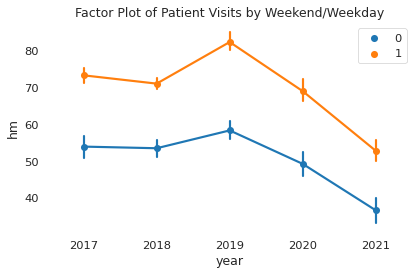

In [40]:
plt1=sns.factorplot('year','hm',hue='weekday',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Patient Visits by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

## **Step #4 Stationary Test**

***`Dickey-Fuller test`***

*   Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
*   Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
* p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
*   p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [42]:
hm_dataset = pd.DataFrame(data=df.values, columns=['year', 'month', 'day', 'day_week', 'weekday', 'hm', 'hm_aw', 'hm_am'],
                          index=pd.date_range(start='2017-07-01', periods=1348, freq='D'))
hm_dataset = hm_dataset.drop(columns = ['year', 'month', 'day', 'day_week'])

Text(0, 0.5, 'Patient Visits Volume')

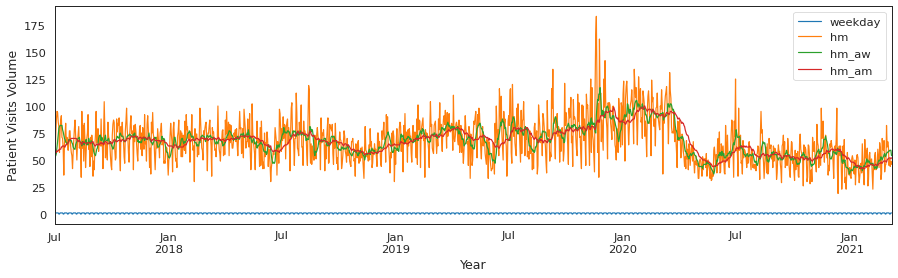

In [43]:
hm_dataset.plot(figsize=(15,4))
plt.xlabel('Year')
plt.ylabel('Patient Visits Volume')

In [44]:
#creating test for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):

  #Perform Dicky Fuller Test:
  print ('Result of Dicky-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], 
                       index=['Test Statistic','p-value','#Lags Used',
                              'Number of Observations Used'])
  
  for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

In [45]:
#Loop to check all columns of the DF
import functools
hm_dataset.apply(functools.partial(test_stationary))

Result of Dicky-Fuller Test:
Test Statistic                   0.0000
p-value                          0.9585
#Lags Used                      10.0000
Number of Observations Used   1337.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                  -2.5335
p-value                          0.1075
#Lags Used                      20.0000
Number of Observations Used   1327.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                  -2.7086
p-value                          0.0726
#Lags Used                      23.0000
Number of Observations Used   1324.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:

weekday    None
hm         None
hm_aw      None
hm_am      None
dtype: object

## **Step #5 Correlation Data Check**

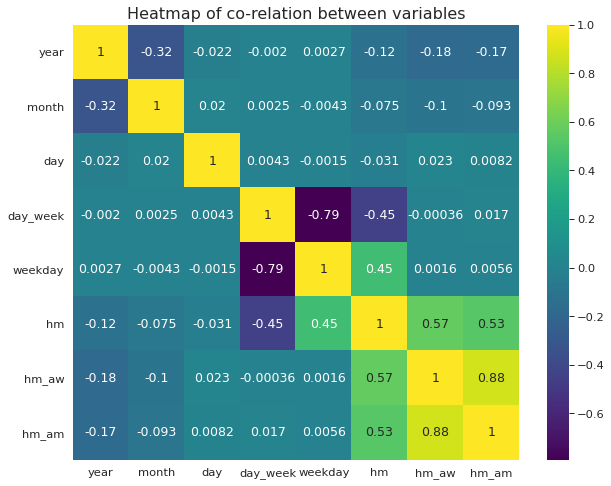

In [46]:
#Use heatmap to see corelation between variables
sns.heatmap(df.corr(),annot=True,cmap='viridis')
plt.title('Heatmap of co-relation between variables',fontsize=16)
plt.show()

In [47]:
print(df.corr())

            year   month     day  day_week  weekday      hm   hm_aw   hm_am
year      1.0000 -0.3220 -0.0216   -0.0020   0.0027 -0.1216 -0.1766 -0.1717
month    -0.3220  1.0000  0.0201    0.0025  -0.0043 -0.0747 -0.1004 -0.0927
day      -0.0216  0.0201  1.0000    0.0043  -0.0015 -0.0313  0.0231  0.0082
day_week -0.0020  0.0025  0.0043    1.0000  -0.7911 -0.4533 -0.0004  0.0174
weekday   0.0027 -0.0043 -0.0015   -0.7911   1.0000  0.4478  0.0016  0.0056
hm       -0.1216 -0.0747 -0.0313   -0.4533   0.4478  1.0000  0.5673  0.5310
hm_aw    -0.1766 -0.1004  0.0231   -0.0004   0.0016  0.5673  1.0000  0.8752
hm_am    -0.1717 -0.0927  0.0082    0.0174   0.0056  0.5310  0.8752  1.0000


## **Step #6 Seasonal Decomposition**

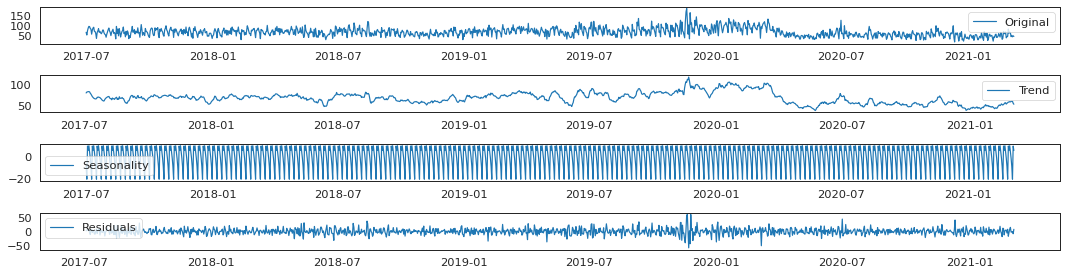

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

x = hm_dataset.hm

x = x.astype(float) # force float
decomposition = seasonal_decompose(x)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,4))

plt.subplot(411)
plt.plot(x, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## **Step #7 Differencing**

In [49]:
data_diff = hm_dataset.diff()

In [50]:
data_diff

,weekday,hm,hm_aw,hm_am
2017-07-01,nan,nan,nan,nan
2017-07-02,0.0000,-13.0000,5.0000,-1.0000
2017-07-03,1.0000,21.0000,1.0000,-3.0000
2017-07-04,0.0000,13.0000,2.0000,-2.0000
2017-07-05,0.0000,8.0000,6.0000,1.0000
...,...,...,...,...
2021-03-05,0.0000,-18.0000,0.0000,1.0000
2021-03-06,-1.0000,6.0000,1.0000,0.0000
2021-03-07,0.0000,-7.0000,0.0000,0.0000
2021-03-08,1.0000,5.0000,0.0000,-1.0000


In [51]:
data_diff.to_csv("data_diff_A.csv")

In [53]:
read = pd.read_csv('data_diff_A.csv')
read

,Unnamed: 0,weekday,hm,hm_aw,hm_am
0,2017-07-01,nan,nan,nan,nan
1,2017-07-02,0.0000,-13.0000,5.0000,-1.0000
2,2017-07-03,1.0000,21.0000,1.0000,-3.0000
3,2017-07-04,0.0000,13.0000,2.0000,-2.0000
4,2017-07-05,0.0000,8.0000,6.0000,1.0000
...,...,...,...,...,...
1343,2021-03-05,0.0000,-18.0000,0.0000,1.0000
1344,2021-03-06,-1.0000,6.0000,1.0000,0.0000
1345,2021-03-07,0.0000,-7.0000,0.0000,0.0000
1346,2021-03-08,1.0000,5.0000,0.0000,-1.0000
